<p style="text-align:center">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="300" alt="Skills Network Logo">
</p>

# Final Project: Building a Rainfall Prediction Classifier
Course clompletion requirement

## Objectives

After completing this lab you will be able to:

* Explore and perform feature engineering on a real-world data set
* Build a classifier pipeline and optimize it using grid search cross validation
* Evaluate your model by interpreting various performance metrics and visualizations
* Implement a different classifier by updating your pipeline
* Use an appropriate set of parameters to search over in each case

## Author

<a href="https://www.linkedin.com/in/pedro-henrique-amorim-de-azevedo-07507b179/" target="_blank">Pedro Azevedo</a>

The dataset you'll use in this project can be downloaded from Kaggle at [https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package?resource=download&select=weatherAUS.csv)  
Column definitions were gathered from [http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml](http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01)  

The dataset contains observations of weather metrics for each day from 2008 to 2017, and includes the following fields:

| Field         | Description                                           | Unit            | Type   |
| :------------ | :---------------------------------------------------- | :-------------- | :----- |
| Date          | Date of the Observation in YYYY-MM-DD                 | Date            | object |
| Location      | Location of the Observation                           | Location        | object |
| MinTemp       | Minimum temperature                                   | Celsius         | float  |
| MaxTemp       | Maximum temperature                                   | Celsius         | float  |
| Rainfall      | Amount of rainfall                                    | Millimeters     | float  |
| Evaporation   | Amount of evaporation                                 | Millimeters     | float  |
| Sunshine      | Amount of bright sunshine                             | hours           | float  |
| WindGustDir   | Direction of the strongest gust                       | Compass Points  | object |
| WindGustSpeed | Speed of the strongest gust                           | Kilometers/Hour | object |
| WindDir9am    | Wind direction averaged over 10 minutes prior to 9am  | Compass Points  | object |
| WindDir3pm    | Wind direction averaged over 10 minutes prior to 3pm  | Compass Points  | object |
| WindSpeed9am  | Wind speed averaged over 10 minutes prior to 9am      | Kilometers/Hour | float  |
| WindSpeed3pm  | Wind speed averaged over 10 minutes prior to 3pm      | Kilometers/Hour | float  |
| Humidity9am   | Humidity at 9am                                       | Percent         | float  |
| Humidity3pm   | Humidity at 3pm                                       | Percent         | float  |
| Pressure9am   | Atmospheric pressure reduced to mean sea level at 9am | Hectopascal     | float  |
| Pressure3pm   | Atmospheric pressure reduced to mean sea level at 3pm | Hectopascal     | float  |
| Cloud9am      | Fraction of the sky obscured by cloud at 9am          | Eights          | float  |
| Cloud3pm      | Fraction of the sky obscured by cloud at 3pm          | Eights          | float  |
| Temp9am       | Temperature at 9am                                    | Celsius         | float  |
| Temp3pm       | Temperature at 3pm                                    | Celsius         | float  |
| RainToday     | If there was at least 1mm of rain today               | Yes/No          | object |
| RainTomorrow  | If there is at least 1mm of rain tomorrow             | Yes/No          | object |

## Install and import the required libraries

In [1]:
!pip install -q numpy 
!pip install -q pandas
!pip install -q matplotlib
!pip install -q scikit-learn==1.5.0
!pip install -q seaborn
!pip install -q xgboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

## Load the data

In [3]:
url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_0eYOqji3unP1tDNKWZMjg/weatherAUS-2.csv"
df = pd.read_csv(url)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# Perform EDA on data
Exploratory Data Analysis

In [4]:
# Get number of entries for each column
df.count()

Date             145460
Location         145460
MinTemp          143975
MaxTemp          144199
Rainfall         142199
Evaporation       82670
Sunshine          75625
WindGustDir      135134
WindGustSpeed    135197
WindDir9am       134894
WindDir3pm       141232
WindSpeed9am     143693
WindSpeed3pm     142398
Humidity9am      142806
Humidity3pm      140953
Pressure9am      130395
Pressure3pm      130432
Cloud9am          89572
Cloud3pm          86102
Temp9am          143693
Temp3pm          141851
RainToday        142199
RainTomorrow     142193
dtype: int64

In [5]:
# Get missing values count
df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [6]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [7]:
df = df.dropna()
df.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

# Consideratons about the dataset

### Data leakage
In this dataset we have columns that contain data from future, which can lead to data leakage. 
This is the case of the 'RainTomorrow' column. To solve this, we can legitimately change the name of rain columns and change our approach to predict today's rainfall with all available data.

In [8]:
df = df.rename(
    columns={
        'RainToday': 'RainYesterday',
        'RainTomorrow': 'RainToday'
    }
)

# Data granularity
Weather patterns change a lot, especially in a large location as Autralia. Our model would have a poor predictability and big complexity do to so. To avoid this e keep things simple, we need to reduce our attention to a smaller region.

Let's keep focused on Melbourne and it's airport which is located only 18km from there.

In [9]:
loc_mask = df['Location'].isin(['Melbourne','MelbourneAirport','Watsonia'])
df = df[loc_mask]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7557 non-null   object 
 1   Location       7557 non-null   object 
 2   MinTemp        7557 non-null   float64
 3   MaxTemp        7557 non-null   float64
 4   Rainfall       7557 non-null   float64
 5   Evaporation    7557 non-null   float64
 6   Sunshine       7557 non-null   float64
 7   WindGustDir    7557 non-null   object 
 8   WindGustSpeed  7557 non-null   float64
 9   WindDir9am     7557 non-null   object 
 10  WindDir3pm     7557 non-null   object 
 11  WindSpeed9am   7557 non-null   float64
 12  WindSpeed3pm   7557 non-null   float64
 13  Humidity9am    7557 non-null   float64
 14  Humidity3pm    7557 non-null   float64
 15  Pressure9am    7557 non-null   float64
 16  Pressure3pm    7557 non-null   float64
 17  Cloud9am       7557 non-null   float64
 18  Cloud3pm

# Creating a seasonality feature
As weather patterns are seasonal, having diferent predictability levels in every season, we can engineer Date column into a Season column.

In [10]:
def date_to_season(date):
    month = date.month
    if (month == 12) or (month == 1) or (month == 2):
        return 'Summer'
    elif month >= 3 and month <= 5:
        return 'Autumn'
    elif month >= 6 and month <= 8:
        return 'Winter'
    elif month >= 9 and month <= 11:
        return 'Spring'

In [11]:
df['Date'] = pd.to_datetime(df['Date'])

# Create Season col
df['Season'] = df['Date'].apply(date_to_season)

# Now drop Date col
df = df.drop(columns=['Date'])

df.sample(5)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainYesterday,RainToday,Season
70327,Melbourne,16.5,20.9,9.4,4.0,0.1,NNW,43.0,NNE,N,...,76.0,1020.8,1019.8,8.0,8.0,17.1,18.5,Yes,Yes,Autumn
65140,MelbourneAirport,3.9,15.5,0.2,2.8,8.0,S,43.0,W,SSW,...,35.0,1020.4,1019.9,1.0,5.0,10.7,13.5,No,No,Spring
78638,Watsonia,17.2,24.0,0.0,8.0,4.2,N,52.0,N,N,...,58.0,1023.0,1020.1,7.0,7.0,19.8,22.9,No,Yes,Spring
79366,Watsonia,10.9,23.5,0.2,3.4,10.1,SSW,31.0,SW,SSW,...,44.0,1011.8,1011.0,4.0,3.0,15.2,23.1,No,No,Spring
70140,Melbourne,17.4,23.1,0.0,11.6,0.8,N,57.0,N,S,...,60.0,1001.9,999.8,8.0,8.0,18.1,17.7,No,Yes,Spring


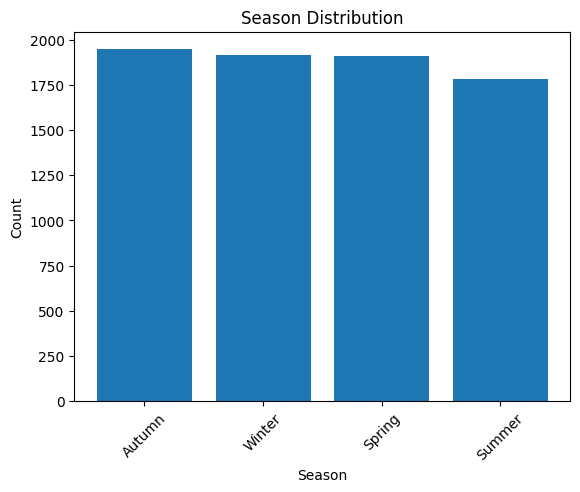

In [12]:
# Let's see how distributed is our new feature across the dataset
season_counts = df['Season'].value_counts()

plt.bar(season_counts.index, season_counts.values)
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Season Distribution')
plt.xticks(rotation=45)  # Rotate labels for better readability if needed
plt.show()

As we can see, the new feature is well distributed and can easily be used by our model without further configuration.

# Define feature and target dataframes

In [13]:
X = df.drop(columns=['RainToday'], axis=1)
y = df['RainToday']

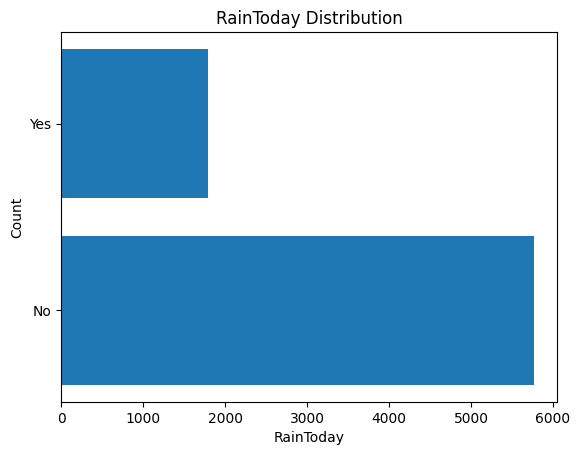

In [14]:
target_count = y.value_counts()

plt.barh(target_count.index, target_count.values)
plt.xlabel('RainToday')
plt.ylabel('Count')
plt.title('RainToday Distribution')
plt.show()

# Caution

It's visible that our target variable is poorly balanced, so we must ensure target stratification through some resampling technique such as Synthetic Minority Oversampling Technique (SMOTE). SMOTE is designed to tackle imbalanced datasets by generating synthetic samples for the minority class. 

# Create preprocessing pipeline

By creating a pipeline, we ensure a single and consistent data preprocessing sequence. And this is where we will implement the SMOTE algorithm.

First, let's split our data into stratified train and test sets. 

In [15]:
# We must ensure stratify=y for better results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Assembly our data pipeline

Now we must separate numeric and categorical features se we can finally create our pipeline

In [16]:
# Separate data columns
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define transformers pipeline for each kind of data
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers into a single preprocessing ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Create a pipeline by combining the preprocessor with a RandomForest model
model_pipeline = Pipeline(steps=[
  	('preprocessor', preprocessor),
  	("SMOTE", SMOTE()),
  	('classifier', RandomForestClassifier(class_weight="balanced", random_state=42)) 
])

# Perform grid search
During grid search we repeatedly test diferent model and transformer parameters using cross-validation methods ensuring we won't touch the test data.

In [17]:
# Define a param grid to use during cross-validation steps
param_grid = {
	'classifier__n_estimators': [100, 300, 500], # Num of trees
    'classifier__max_depth': [None, 10, 20, 30], # Max depth of each tree
    'classifier__min_samples_split': [2, 5, 10], # Min of samples to split a tree node 
    'classifier__min_samples_leaf': [1, 2, 4], # Min of samples per leaf
    'classifier__bootstrap': [True], # Use bootstrap sampling 
    'classifier__max_features': ['sqrt', 'log2'] # Num of features to be use in each node split
}

# Select cross-validation method
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Instantiate GridSearchCV using our pipeline
grid_search = GridSearchCV(model_pipeline, param_grid, cv=cv, scoring='accuracy', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)
	

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   2.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   2.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   2.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   2.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pr...
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__bootstrap': [True],
                         'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__max_features': ['sqrt', 'log2'],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 300, 500]},
             scoring='accuracy', verbose=2)

# Evaluating our model

Now that we finished training our model, let's take a closer look on the metrics.

In [18]:
print("Best parameters found: ", grid_search.best_params_)

# Get best scoring during cross-validation
best_cv_score = grid_search.best_score_
print("Best training score: {:.2f}".format(best_cv_score))

# Now get scoring for test data
test_score = grid_search.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Best parameters found:  {'classifier__bootstrap': True, 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 500}
Best training score: 0.84
Test set score: 0.85


As we can see, the score on the test set is quite close to the training score, which is good, but it can still be better.

### Classification Report

Let's take a closer look at our model's metrics and see if we can improve it further.

In [19]:
# Get the best estimator and do some predictions on unseen data
y_pred = grid_search.best_estimator_.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

          No       0.90      0.91      0.90      1154
         Yes       0.70      0.66      0.68       358

    accuracy                           0.85      1512
   macro avg       0.80      0.78      0.79      1512
weighted avg       0.85      0.85      0.85      1512



### Confusion Matrix

By plotting the confusion matrix we can get visual feedback of how well our model is performing.

Text(0.5, 1.0, 'Confusion Matrix')

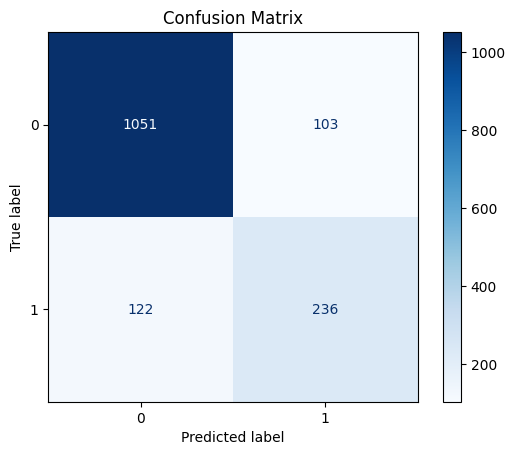

In [20]:
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')

# Extracting feature importances

In order to understand how the dataset influences the predictions of our model, we will extract the feature importances and identify the features with the most effect on the target variable.

In [21]:
# Associate feature importances with their original input variables
cat_features_backward = list(
  	grid_search.best_estimator_['preprocessor']
	.named_transformers_['cat']
	.named_steps['onehot']
	.get_feature_names_out(categorical_features)
)

# Combine numeric and categorical feature names
feature_names = numeric_features + cat_features_backward

feature_importances = grid_search.best_estimator_['classifier'].feature_importances_
importance_df = pd.DataFrame({
  	'Feature': feature_names,
  	'Importance': feature_importances
})
n_selected_features = 5
top_features = importance_df.sort_values(by='Importance', ascending=False)[:n_selected_features]
top_features.head(n_selected_features)

,Feature,Importance
4,Sunshine,0.094471
11,Pressure3pm,0.092671
9,Humidity3pm,0.089845
10,Pressure9am,0.072488
13,Cloud3pm,0.061596


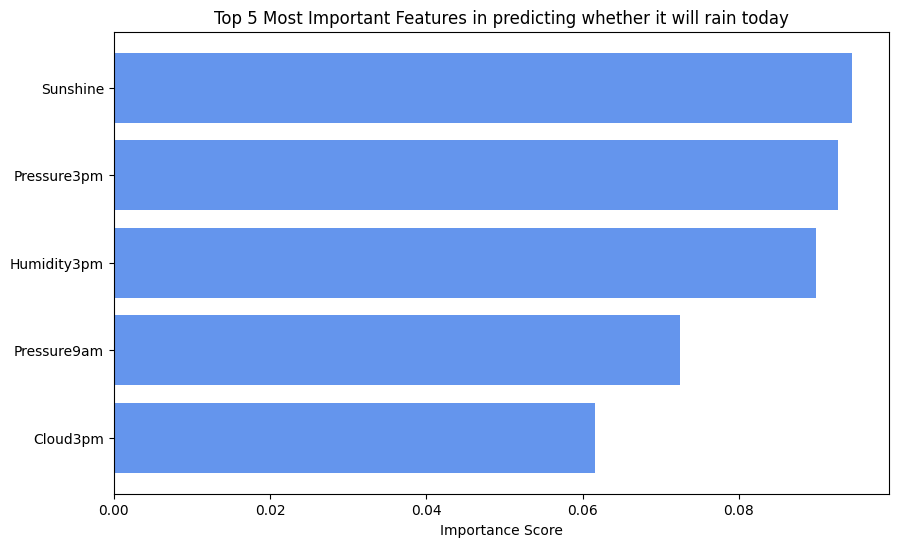

In [22]:
# Plot importances
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='cornflowerblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title(f'Top {n_selected_features} Most Important Features in predicting whether it will rain today')
plt.xlabel('Importance Score')
plt.show()

# Using best features

Now that we know which are the best features for our model, let's train another model using them and see if can we improve it even more.

In [23]:
X = df[top_features['Feature']]
y = df['RainToday']

X.head()

,Sunshine,Pressure3pm,Humidity3pm,Pressure9am,Cloud3pm
64191,8.8,1006.4,37.0,1005.1,7.0
64192,12.9,1019.3,43.0,1018.0,7.0
64193,10.5,1017.6,35.0,1020.8,7.0
64194,12.5,1012.8,23.0,1016.2,4.0
64195,12.3,1010.3,31.0,1011.9,2.0


Since we changed the columns count in our dataset, we also need to redefine our entire pipeline to work with the new set of columns.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

model_pipeline = Pipeline(steps=[
  	('preprocessor', preprocessor),
  	("SMOTE", SMOTE()),
  	('classifier', RandomForestClassifier(class_weight="balanced", random_state=42)) 
])

param_grid = {
	'classifier__n_estimators': [100, 300, 500], # Num of trees
    'classifier__max_depth': [None, 10, 20, 30], # Max depth of each tree
    'classifier__min_samples_split': [2, 5, 10], # Min of samples to split a tree node 
    'classifier__min_samples_leaf': [1, 2, 4], # Min of samples per leaf
    'classifier__bootstrap': [True], # Use bootstrap sampling 
    'classifier__max_features': ['sqrt', 'log2'] # Num of features to be use in each node split
}

cv = StratifiedKFold(n_splits=5, shuffle=True)

grid_search = GridSearchCV(model_pipeline, param_grid, cv=cv, scoring='accuracy', verbose=2, n_jobs=-1)

# Train a new Classifier with only the best columns
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Sunshine',
                                                                          'Pressure3pm',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Cloud3pm']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         [])]))...
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__bootstrap': [True],
                         'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__max_features': ['sqrt', 'log2'],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 300, 500]},
             scoring='accuracy', verbose=2)

In [25]:
print("Best parameters found: ", grid_search.best_params_)

# Get best scoring during cross-validation
best_cv_score = grid_search.best_score_
print("Best training score: {:.2f}".format(best_cv_score))

# Now get scoring for test data
test_score = grid_search.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

# Get the best estimator and do some predictions on unseen data
y_pred = grid_search.best_estimator_.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Best parameters found:  {'classifier__bootstrap': True, 'classifier__max_depth': 30, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 500}
Best training score: 0.84
Test set score: 0.85
Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.89      0.90      1154
         Yes       0.67      0.74      0.70       358

    accuracy                           0.85      1512
   macro avg       0.79      0.81      0.80      1512
weighted avg       0.86      0.85      0.86      1512



As we can see, for the 'Yes' class recall increased from 0.66 to 0.74 which means that we have less instaces being misclassified as false positives. F1 score went from 0.68 to 0.70. Precision for the 'No' class also increased to 0.92 (previously 0.90). The precision for 'Yes' dropped from 0.70 to 0.67 but we still got good results as we can see at the confusion matrix.

Text(0.5, 1.0, 'Confusion Matrix')

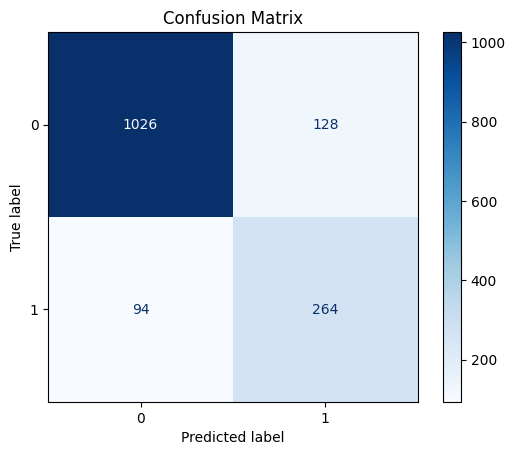

In [26]:
# Let's take a look at the confusion matrix for this new model
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')